We'll start by importing all necessary libraries.

In [1]:
import pandas as pd
pd.set_option('display.max_columns', None)
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import cross_val_score, cross_validate
from sklearn.neighbors import KNeighborsClassifier
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import classification_report
from sklearn.svm import SVC
from sklearn import tree
from warnings import simplefilter
simplefilter(action='ignore', category=FutureWarning)
import tensorflow.keras as keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
import visualkeras
import tensorflow as tf
tf.data.experimental.enable_debug_mode()
from tensorflow.keras.callbacks import ModelCheckpoint
from tqdm.notebook import tqdm_notebook

Loading the two datasets that will be used. The '15-'16 season will be used for training, while the next season is used for testing

In [2]:
df_train1 = pd.read_csv('data/NBA_PBP_2015-16.csv')
df_train2 = pd.read_csv('data/NBA_PBP_2016-17.csv')
df_train3 = pd.read_csv('data/NBA_PBP_2017-18.csv')
df_train4 = pd.read_csv('data/NBA_PBP_2018-19.csv')
df_train5 = pd.read_csv('data/NBA_PBP_2019-20.csv')

del df_train5['Unnamed: 40']

df_train = pd.concat([df_train1, df_train2, df_train3, df_train4, df_train5])

df_test = pd.read_csv('test data/NBA_PBP_2020-21.csv')

In [3]:
df_train = df_train.reset_index(drop=True)

Below, we have the selected features and a list of their names for the feature vectors that will be constructed later.

In [4]:
factors = ['ShotDist','FoulType',
           'TimeoutTeam','Substitution', 'Shooter',
           'Rebounder', 'Blocker','Fouler',
          'Fouled','ReboundType','ViolationPlayer', 'ViolationType',
          'FreeThrowShooter','TurnoverPlayer','TurnoverType','TurnoverCause',
           'TurnoverCauser']

fact_cols = [col + str((i // 17) % 10 + 1) for i, col in enumerate(factors * 10)]
fact_cols.append('class')

In [5]:
# factors = ['ShotDist','FoulType','TimeoutTeam','ReboundType', 'ViolationType','TurnoverType']

# fact_cols = [col + str((i // 6) % 10 + 1) for i, col in enumerate(factors * 10)]
# fact_cols.append('class')


In [6]:
df_train['ShotDist'] = df_train.ShotDist.apply(lambda x: 'close' if x <= 10 else '3pt' if x >= 22 else 'mid' if pd.notna(x) else x)
# df_train['FoulType'] = df_train.FoulType.apply(lambda x: 'foul' if pd.notna(x) else x)
# df_train['ViolationType'] = df_train.ViolationType.apply(lambda x: 'violation' if pd.notna(x) else x)
# df_train['TurnoverType'] = df_train.TurnoverType.apply(lambda x: 'turnover' if pd.notna(x) else x)
df_train['TimeoutTeam'] = df_train.apply(
    lambda row: 'timeout_home' if pd.notna(row['TimeoutTeam']) and row['TimeoutTeam'] == row['HomeTeam'] 
    else 'timeout_away' if pd.notna(row['TimeoutTeam']) 
    else row['TimeoutTeam'], 
    axis=1
)

df_train['TurnoverType'] = df_train.apply(lambda row: 'turnover_home' if pd.notna(row['TurnoverType']) and pd.notna(row['HomePlay'])
                                     else 'turnover_away' if pd.notna(row['TurnoverType']) and pd.notna(row['AwayPlay'])
                                     else np.nan,
                                     axis=1)

df_train['ViolationType'] = df_train.apply(lambda row: 'violation_home' if pd.notna(row['ViolationType']) and pd.notna(row['HomePlay'])
                                     else 'violation_away' if pd.notna(row['ViolationType']) and pd.notna(row['AwayPlay'])
                                     else np.nan,
                                     axis=1)

df_train['FoulType'] = df_train.apply(lambda row: 'foul_home' if pd.notna(row['FoulType']) and pd.notna(row['HomePlay'])
                                     else 'foul_away' if pd.notna(row['FoulType']) and pd.notna(row['AwayPlay'])
                                     else np.nan,
                                     axis=1)

df_train['Shooter'] = df_train.apply(lambda row: 'shooter_home' if pd.notna(row['Shooter']) and pd.notna(row['HomePlay'])
                                     else 'shooter_away' if pd.notna(row['Shooter']) and pd.notna(row['AwayPlay'])
                                     else np.nan,
                                     axis=1)

df_train['Rebounder'] = df_train.apply(lambda row: 'rebounder_home' if pd.notna(row['Rebounder']) and pd.notna(row['HomePlay'])
                                     else 'rebounder_away' if pd.notna(row['Rebounder']) and pd.notna(row['AwayPlay'])
                                     else np.nan,
                                     axis=1)

df_train['Blocker'] = df_train.apply(lambda row: 'blocker_home' if pd.notna(row['Blocker']) and pd.notna(row['HomePlay'])
                                     else 'blocker_away' if pd.notna(row['Blocker']) and pd.notna(row['AwayPlay'])
                                     else np.nan,
                                     axis=1)

df_train['Fouler'] = df_train.apply(lambda row: 'fouler_home' if pd.notna(row['Fouler']) and pd.notna(row['HomePlay'])
                                     else 'fouler_away' if pd.notna(row['Fouler']) and pd.notna(row['AwayPlay'])
                                     else np.nan,
                                     axis=1)

df_train['Fouled'] = df_train.apply(lambda row: 'fouled_home' if pd.notna(row['Fouled']) and pd.notna(row['HomePlay'])
                                     else 'fouled_away' if pd.notna(row['Fouled']) and pd.notna(row['AwayPlay'])
                                     else np.nan,
                                     axis=1)

df_train['ViolationPlayer'] = df_train.apply(lambda row: 'violation_home' if pd.notna(row['ViolationPlayer']) and pd.notna(row['HomePlay'])
                                     else 'violation_away' if pd.notna(row['ViolationPlayer']) and pd.notna(row['AwayPlay'])
                                     else np.nan,
                                     axis=1)

df_train['FreeThrowShooter'] = df_train.apply(lambda row: 'ft_home' if pd.notna(row['FreeThrowShooter']) and pd.notna(row['HomePlay'])
                                     else 'ft_away' if pd.notna(row['FreeThrowShooter']) and pd.notna(row['AwayPlay'])
                                     else np.nan,
                                     axis=1)

df_train['TurnoverPlayer'] = df_train.apply(lambda row: 'turnover_home' if pd.notna(row['TurnoverPlayer']) and pd.notna(row['HomePlay'])
                                     else 'turnover_away' if pd.notna(row['TurnoverPlayer']) and pd.notna(row['AwayPlay'])
                                     else np.nan,
                                     axis=1)

df_train['TurnoverCauser'] = df_train.apply(lambda row: 'to_causer_home' if pd.notna(row['TurnoverCauser']) and pd.notna(row['HomePlay'])
                                     else 'to_causer_away' if pd.notna(row['TurnoverCauser']) and pd.notna(row['AwayPlay'])
                                     else np.nan,
                                     axis=1)

df_train['Substitution'] = df_train.apply(lambda row: 'sub_home' if pd.notna(row['EnterGame']) and pd.notna(row['HomePlay'])
                                              else 'sub_away' if pd.notna(row['EnterGame']) and pd.notna(row['AwayPlay'])
                                              else np.nan,
                                              axis=1)



The encoders() function creates a different label encoder instance for each feature so that they can be encoded and decoded independently.

The next two functions iterate over the whole dataframe and creates lists of the moments a basket that contributes to a run occurs.


In [7]:
def home_runner(data):
    global home_runs
    run = []
    home_runs = []
    for idx in data.index:
        if data.at[idx,'HomePlay'] is not np.nan:
                if 'makes' in data.at[idx,'HomePlay']:
                    run.append(idx)
        elif data.at[idx,'AwayPlay'] is not np.nan:
                if 'makes' in data.at[idx,'AwayPlay']:
                    run.clear()
        if len(run) == 4:
            home_runs.append(run.copy())
            run.clear()
    return home_runs
                

home_runner(df_train)



def away_runner(data):
    global away_runs
    run = []
    away_runs = []
    for idx in data.index:
        if data.at[idx,'AwayPlay'] is not np.nan:
                if 'makes' in data.at[idx,'AwayPlay']:
                    run.append(idx)
        elif data.at[idx,'HomePlay'] is not np.nan:
                if 'makes' in data.at[idx,'HomePlay']:
                    run.clear()
        if len(run) == 4:
            away_runs.append(run.copy())
            run.clear()
    return away_runs

away_runner(df_train)

all_runs = []
all_runs.extend(home_runs)
all_runs.extend(away_runs)


The runs_iter() function looks for 10 events before the start of the run. It then picks specific columns of interest. The data from those columns get flattened in an 1d array, which is then added to a new dataframe, along with a label that indicates this is a run.

In [8]:
df_train = df_train[factors]

In [9]:
df_train.head(1)

,ShotDist,FoulType,TimeoutTeam,Substitution,Shooter,Rebounder,Blocker,Fouler,Fouled,ReboundType,ViolationPlayer,ViolationType,FreeThrowShooter,TurnoverPlayer,TurnoverType,TurnoverCause,TurnoverCauser
0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [10]:
#The data from those columns get flattened in an 1d array, which is then added to a new dataframe, along with a label
#that indicates this is a run.

def runs_iter(data):
    global runs_df
    runs_df = pd.DataFrame()
    for run in all_runs:
        a = data.loc[run[0]-10:run[0]-1, factors].values.ravel()
        a = np.append(a,1)
        runs_df = pd.concat([runs_df,pd.DataFrame([a.copy()])])
    return runs_df

runs_iter(df_train)
runs_df.columns = fact_cols
runs_df

,ShotDist1,FoulType1,TimeoutTeam1,Substitution1,Shooter1,Rebounder1,Blocker1,Fouler1,Fouled1,ReboundType1,ViolationPlayer1,ViolationType1,FreeThrowShooter1,TurnoverPlayer1,TurnoverType1,TurnoverCause1,TurnoverCauser1,ShotDist2,FoulType2,TimeoutTeam2,Substitution2,Shooter2,Rebounder2,Blocker2,Fouler2,Fouled2,ReboundType2,ViolationPlayer2,ViolationType2,FreeThrowShooter2,TurnoverPlayer2,TurnoverType2,TurnoverCause2,TurnoverCauser2,ShotDist3,FoulType3,TimeoutTeam3,Substitution3,Shooter3,Rebounder3,Blocker3,Fouler3,Fouled3,ReboundType3,ViolationPlayer3,ViolationType3,FreeThrowShooter3,TurnoverPlayer3,TurnoverType3,TurnoverCause3,TurnoverCauser3,ShotDist4,FoulType4,TimeoutTeam4,Substitution4,Shooter4,Rebounder4,Blocker4,Fouler4,Fouled4,ReboundType4,ViolationPlayer4,ViolationType4,FreeThrowShooter4,TurnoverPlayer4,TurnoverType4,TurnoverCause4,TurnoverCauser4,ShotDist5,FoulType5,TimeoutTeam5,Substitution5,Shooter5,Rebounder5,Blocker5,Fouler5,Fouled5,ReboundType5,ViolationPlayer5,ViolationType5,FreeThrowShooter5,TurnoverPlayer5,TurnoverType5,TurnoverCause5,TurnoverCauser5,ShotDist6,FoulType6,TimeoutTeam6,Substitution6,Shooter6,Rebounder6,Blocker6,Fouler6,Fouled6,ReboundType6,ViolationPlayer6,ViolationType6,FreeThrowShooter6,TurnoverPlayer6,TurnoverType6,TurnoverCause6,TurnoverCauser6,ShotDist7,FoulType7,TimeoutTeam7,Substitution7,Shooter7,Rebounder7,Blocker7,Fouler7,Fouled7,ReboundType7,ViolationPlayer7,ViolationType7,FreeThrowShooter7,TurnoverPlayer7,TurnoverType7,TurnoverCause7,TurnoverCauser7,ShotDist8,FoulType8,TimeoutTeam8,Substitution8,Shooter8,Rebounder8,Blocker8,Fouler8,Fouled8,ReboundType8,ViolationPlayer8,ViolationType8,FreeThrowShooter8,TurnoverPlayer8,TurnoverType8,TurnoverCause8,TurnoverCauser8,ShotDist9,FoulType9,TimeoutTeam9,Substitution9,Shooter9,Rebounder9,Blocker9,Fouler9,Fouled9,ReboundType9,ViolationPlayer9,ViolationType9,FreeThrowShooter9,TurnoverPlayer9,TurnoverType9,TurnoverCause9,TurnoverCauser9,ShotDist10,FoulType10,TimeoutTeam10,Substitution10,Shooter10,Rebounder10,Blocker10,Fouler10,Fouled10,ReboundType10,ViolationPlayer10,ViolationType10,FreeThrowShooter10,TurnoverPlayer10,TurnoverType10,TurnoverCause10,TurnoverCauser10,class
0,NaN,foul_away,NaN,NaN,NaN,NaN,NaN,fouler_away,fouled_away,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,ft_away,NaN,NaN,NaN,NaN,close,NaN,NaN,NaN,shooter_home,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,mid,NaN,NaN,NaN,shooter_away,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,rebounder_home,NaN,NaN,NaN,defensive,NaN,NaN,NaN,NaN,NaN,NaN,NaN,mid,NaN,NaN,NaN,shooter_home,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,rebounder_away,NaN,NaN,NaN,defensive,NaN,NaN,NaN,NaN,NaN,NaN,NaN,close,NaN,NaN,NaN,shooter_away,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,turnover_home,turnover_home,steal,to_causer_home,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,turnover_away,turnover_away,steal,to_causer_away,1
0,NaN,NaN,NaN,NaN,NaN,rebounder_away,NaN,NaN,NaN,offensive,NaN,NaN,NaN,NaN,NaN,NaN,NaN,close,NaN,NaN,NaN,shooter_away,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,rebounder_away,NaN,NaN,NaN,offensive,NaN,NaN,NaN,NaN,NaN,NaN,NaN,close,NaN,NaN,NaN,shooter_away,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,foul_home,NaN,NaN,NaN,NaN,NaN,fouler_home,fouled_home,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,ft_home,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,rebounder_home,NaN,NaN,NaN,offensive,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,sub_away,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,sub_home,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,sub_home,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1
0,close,NaN,NaN,NaN,shooter_home,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,rebounder_away,NaN,NaN,NaN,defensive,NaN,NaN,NaN,NaN,NaN,NaN,NaN,3p

The precipitating events for the runs are removed from the dataframe and a similar function assigns labels of 0 to no_runs.

In [11]:
def no_runs_preprocessing(data):
    global no_runs_split
    
    # find the first index of a run
    r = [i[0] for i in all_runs]  

    # create a list of runs
    r_x = []
    for num in r:
        r_x.extend(range(num - 10, num + 1))

    # mask the df without runs
    no_runs_df = data[~data.index.isin(r_x)].reset_index(drop=True)

    # segment the df and keep those that are length of 10
    segment_size = 10
    segments = len(no_runs_df) // segment_size

    no_runs_split = np.array_split(no_runs_df, segments)

    no_runs_split = [x for x in no_runs_split if len(x) != 11]

    return no_runs_split

In [12]:
def no_runs_optimized(data, factors, fact_cols):
    global no_runs_df
    no_runs_df = pd.DataFrame([np.append(segment.loc[:, factors].values.ravel(), int(0)) for segment in data])
    no_runs_df.columns = fact_cols
    return no_runs_df

no_runs_optimized(no_runs_preprocessing(df_train), factors, fact_cols)

,ShotDist1,FoulType1,TimeoutTeam1,Substitution1,Shooter1,Rebounder1,Blocker1,Fouler1,Fouled1,ReboundType1,ViolationPlayer1,ViolationType1,FreeThrowShooter1,TurnoverPlayer1,TurnoverType1,TurnoverCause1,TurnoverCauser1,ShotDist2,FoulType2,TimeoutTeam2,Substitution2,Shooter2,Rebounder2,Blocker2,Fouler2,Fouled2,ReboundType2,ViolationPlayer2,ViolationType2,FreeThrowShooter2,TurnoverPlayer2,TurnoverType2,TurnoverCause2,TurnoverCauser2,ShotDist3,FoulType3,TimeoutTeam3,Substitution3,Shooter3,Rebounder3,Blocker3,Fouler3,Fouled3,ReboundType3,ViolationPlayer3,ViolationType3,FreeThrowShooter3,TurnoverPlayer3,TurnoverType3,TurnoverCause3,TurnoverCauser3,ShotDist4,FoulType4,TimeoutTeam4,Substitution4,Shooter4,Rebounder4,Blocker4,Fouler4,Fouled4,ReboundType4,ViolationPlayer4,ViolationType4,FreeThrowShooter4,TurnoverPlayer4,TurnoverType4,TurnoverCause4,TurnoverCauser4,ShotDist5,FoulType5,TimeoutTeam5,Substitution5,Shooter5,Rebounder5,Blocker5,Fouler5,Fouled5,ReboundType5,ViolationPlayer5,ViolationType5,FreeThrowShooter5,TurnoverPlayer5,TurnoverType5,TurnoverCause5,TurnoverCauser5,ShotDist6,FoulType6,TimeoutTeam6,Substitution6,Shooter6,Rebounder6,Blocker6,Fouler6,Fouled6,ReboundType6,ViolationPlayer6,ViolationType6,FreeThrowShooter6,TurnoverPlayer6,TurnoverType6,TurnoverCause6,TurnoverCauser6,ShotDist7,FoulType7,TimeoutTeam7,Substitution7,Shooter7,Rebounder7,Blocker7,Fouler7,Fouled7,ReboundType7,ViolationPlayer7,ViolationType7,FreeThrowShooter7,TurnoverPlayer7,TurnoverType7,TurnoverCause7,TurnoverCauser7,ShotDist8,FoulType8,TimeoutTeam8,Substitution8,Shooter8,Rebounder8,Blocker8,Fouler8,Fouled8,ReboundType8,ViolationPlayer8,ViolationType8,FreeThrowShooter8,TurnoverPlayer8,TurnoverType8,TurnoverCause8,TurnoverCauser8,ShotDist9,FoulType9,TimeoutTeam9,Substitution9,Shooter9,Rebounder9,Blocker9,Fouler9,Fouled9,ReboundType9,ViolationPlayer9,ViolationType9,FreeThrowShooter9,TurnoverPlayer9,TurnoverType9,TurnoverCause9,TurnoverCauser9,ShotDist10,FoulType10,TimeoutTeam10,Substitution10,Shooter10,Rebounder10,Blocker10,Fouler10,Fouled10,ReboundType10,ViolationPlayer10,ViolationType10,FreeThrowShooter10,TurnoverPlayer10,TurnoverType10,TurnoverCause10,TurnoverCauser10,class
0,NaN,NaN,NaN,sub_away,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,sub_away,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,sub_home,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,close,NaN,NaN,NaN,shooter_home,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,mid,NaN,NaN,NaN,shooter_away,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,rebounder_home,NaN,NaN,NaN,defensive,NaN,NaN,NaN,NaN,NaN,NaN,NaN,close,NaN,NaN,NaN,shooter_home,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,turnover_away,turnover_away,steal,to_causer_away,3pt,NaN,NaN,NaN,shooter_home,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,turnover_away,turnover_away,steal,to_causer_away,0
1,close,NaN,NaN,NaN,shooter_home,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,rebounder_away,NaN,NaN,NaN,defensive,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,foul_home,NaN,NaN,NaN,NaN,NaN,fouler_home,fouled_home,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,sub_away,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,sub_home,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,3pt,NaN,NaN,NaN,shooter_away,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,rebounder_away,NaN,NaN,NaN,offensive,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,violation_home,violation_home,NaN,NaN,NaN,NaN,NaN,mid,NaN,NaN,NaN,shooter_home,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0
2,NaN,NaN,NaN,NaN,NaN,rebounder_away,NaN,NaN,NaN,defensive,NaN,NaN,NaN,NaN,NaN,NaN,NaN,mid,NaN,NaN,NaN,shooter_away,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,rebounder

To avoid label imbalance, we'll undersample the no_runs dataframe.

In [13]:
no_runs_df=no_runs_df.sample(frac=0.14)

We'll combine the two frames into a final one.

In [14]:
combined_df = pd.concat([runs_df,no_runs_df],ignore_index=True)
# final_df = combined_df.dropna().astype(int)
combined_df

,ShotDist1,FoulType1,TimeoutTeam1,Substitution1,Shooter1,Rebounder1,Blocker1,Fouler1,Fouled1,ReboundType1,ViolationPlayer1,ViolationType1,FreeThrowShooter1,TurnoverPlayer1,TurnoverType1,TurnoverCause1,TurnoverCauser1,ShotDist2,FoulType2,TimeoutTeam2,Substitution2,Shooter2,Rebounder2,Blocker2,Fouler2,Fouled2,ReboundType2,ViolationPlayer2,ViolationType2,FreeThrowShooter2,TurnoverPlayer2,TurnoverType2,TurnoverCause2,TurnoverCauser2,ShotDist3,FoulType3,TimeoutTeam3,Substitution3,Shooter3,Rebounder3,Blocker3,Fouler3,Fouled3,ReboundType3,ViolationPlayer3,ViolationType3,FreeThrowShooter3,TurnoverPlayer3,TurnoverType3,TurnoverCause3,TurnoverCauser3,ShotDist4,FoulType4,TimeoutTeam4,Substitution4,Shooter4,Rebounder4,Blocker4,Fouler4,Fouled4,ReboundType4,ViolationPlayer4,ViolationType4,FreeThrowShooter4,TurnoverPlayer4,TurnoverType4,TurnoverCause4,TurnoverCauser4,ShotDist5,FoulType5,TimeoutTeam5,Substitution5,Shooter5,Rebounder5,Blocker5,Fouler5,Fouled5,ReboundType5,ViolationPlayer5,ViolationType5,FreeThrowShooter5,TurnoverPlayer5,TurnoverType5,TurnoverCause5,TurnoverCauser5,ShotDist6,FoulType6,TimeoutTeam6,Substitution6,Shooter6,Rebounder6,Blocker6,Fouler6,Fouled6,ReboundType6,ViolationPlayer6,ViolationType6,FreeThrowShooter6,TurnoverPlayer6,TurnoverType6,TurnoverCause6,TurnoverCauser6,ShotDist7,FoulType7,TimeoutTeam7,Substitution7,Shooter7,Rebounder7,Blocker7,Fouler7,Fouled7,ReboundType7,ViolationPlayer7,ViolationType7,FreeThrowShooter7,TurnoverPlayer7,TurnoverType7,TurnoverCause7,TurnoverCauser7,ShotDist8,FoulType8,TimeoutTeam8,Substitution8,Shooter8,Rebounder8,Blocker8,Fouler8,Fouled8,ReboundType8,ViolationPlayer8,ViolationType8,FreeThrowShooter8,TurnoverPlayer8,TurnoverType8,TurnoverCause8,TurnoverCauser8,ShotDist9,FoulType9,TimeoutTeam9,Substitution9,Shooter9,Rebounder9,Blocker9,Fouler9,Fouled9,ReboundType9,ViolationPlayer9,ViolationType9,FreeThrowShooter9,TurnoverPlayer9,TurnoverType9,TurnoverCause9,TurnoverCauser9,ShotDist10,FoulType10,TimeoutTeam10,Substitution10,Shooter10,Rebounder10,Blocker10,Fouler10,Fouled10,ReboundType10,ViolationPlayer10,ViolationType10,FreeThrowShooter10,TurnoverPlayer10,TurnoverType10,TurnoverCause10,TurnoverCauser10,class
0,NaN,foul_away,NaN,NaN,NaN,NaN,NaN,fouler_away,fouled_away,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,ft_away,NaN,NaN,NaN,NaN,close,NaN,NaN,NaN,shooter_home,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,mid,NaN,NaN,NaN,shooter_away,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,rebounder_home,NaN,NaN,NaN,defensive,NaN,NaN,NaN,NaN,NaN,NaN,NaN,mid,NaN,NaN,NaN,shooter_home,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,rebounder_away,NaN,NaN,NaN,defensive,NaN,NaN,NaN,NaN,NaN,NaN,NaN,close,NaN,NaN,NaN,shooter_away,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,turnover_home,turnover_home,steal,to_causer_home,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,turnover_away,turnover_away,steal,to_causer_away,1
1,NaN,NaN,NaN,NaN,NaN,rebounder_away,NaN,NaN,NaN,offensive,NaN,NaN,NaN,NaN,NaN,NaN,NaN,close,NaN,NaN,NaN,shooter_away,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,rebounder_away,NaN,NaN,NaN,offensive,NaN,NaN,NaN,NaN,NaN,NaN,NaN,close,NaN,NaN,NaN,shooter_away,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,foul_home,NaN,NaN,NaN,NaN,NaN,fouler_home,fouled_home,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,ft_home,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,rebounder_home,NaN,NaN,NaN,offensive,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,sub_away,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,sub_home,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,sub_home,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1
2,close,NaN,NaN,NaN,shooter_home,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,rebounder_away,NaN,NaN,NaN,defensive,NaN,NaN,NaN,NaN,NaN,NaN,NaN,3p

In [15]:
combined_df.fillna(0, inplace=True)

In [16]:

df = pd.DataFrame()

for column in combined_df.columns[:-1]:
    dum = pd.get_dummies(combined_df[column], dtype='int')
    df = pd.concat([df,dum],axis=1)



In [19]:
df

,0,3pt,close,mid,0,foul_away,foul_home,0,timeout_away,timeout_home,0,sub_away,sub_home,0,shooter_away,shooter_home,0,rebounder_away,rebounder_home,0,blocker_away,blocker_home,0,fouler_away,fouler_home,0,fouled_away,fouled_home,0,defensive,offensive,0,violation_away,violation_home,0,violation_away,violation_home,0,ft_away,ft_home,0,turnover_away,turnover_home,0,turnover_away,turnover_home,0,steal,0,to_causer_away,to_causer_home,0,3pt,close,mid,0,foul_away,foul_home,0,timeout_away,timeout_home,0,sub_away,sub_home,0,shooter_away,shooter_home,0,rebounder_away,rebounder_home,0,blocker_away,blocker_home,0,fouler_away,fouler_home,0,fouled_away,fouled_home,0,defensive,offensive,0,violation_away,violation_home,0,violation_away,violation_home,0,ft_away,ft_home,0,turnover_away,turnover_home,0,turnover_away,turnover_home,0,steal,0,to_causer_away,to_causer_home,0,3pt,close,mid,0,foul_away,foul_home,0,timeout_away,timeout_home,0,sub_away,sub_home,0,shooter_away,shooter_home,0,rebounder_away,rebounder_home,0,blocker_away,blocker_home,0,fouler_away,fouler_home,0,fouled_away,fouled_home,0,defensive,offensive,0,violation_away,violation_home,0,violation_away,violation_home,0,ft_away,ft_home,0,turnover_away,turnover_home,0,turnover_away,turnover_home,0,steal,0,to_causer_away,to_causer_home,0,3pt,close,mid,0,foul_away,foul_home,0,timeout_away,timeout_home,0,sub_away,sub_home,0,shooter_away,shooter_home,0,rebounder_away,rebounder_home,0,blocker_away,blocker_home,0,fouler_away,fouler_home,0,fouled_away,fouled_home,0,defensive,offensive,0,violation_away,violation_home,0,violation_away,violation_home,0,ft_away,ft_home,0,turnover_away,turnover_home,0,turnover_away,turnover_home,0,steal,0,to_causer_away,to_causer_home,0,3pt,close,mid,0,foul_away,foul_home,0,timeout_away,timeout_home,0,sub_away,sub_home,0,shooter_away,shooter_home,0,rebounder_away,rebounder_home,0,blocker_away,blocker_home,0,fouler_away,fouler_home,0,fouled_away,fouled_home,0,defensive,offensive,0,violation_away,violation_home,0,violation_away,violation_home,0,ft_away,ft_home,0,turnover_away,turnover_home,0,turnover_away,turnover_home,0,steal,0,to_causer_away,to_causer_home,0,3pt,close,mid,0,foul_away,foul_home,0,timeout_away,timeout_home,0,sub_away,sub_home,0,shooter_away,shooter_home,0,rebounder_away,rebounder_home,0,blocker_away,blocker_home,0,fouler_away,fouler_home,0,fouled_away,fouled_home,0,defensive,offensive,0,violation_away,violation_home,0,violation_away,violation_home,0,ft_away,ft_home,0,turnover_away,turnover_home,0,turnover_away,turnover_home,0,steal,0,to_causer_away,to_causer_home,0,3pt,close,mid,0,foul_away,foul_home,0,timeout_away,timeout_home,0,sub_away,sub_home,0,shooter_away,shooter_home,0,rebounder_away,rebounder_home,0,blocker_away,blocker_home,0,fouler_away,fouler_home,0,fouled_away,fouled_home,0,defensive,offensive,0,violation_away,violation_home,0,violation_away,violation_home,0,ft_away,ft_home,0,turnover_away,turnover_home,0,turnover_away,turnover_home,0,steal,0,to_causer_away,to_causer_home,0,3pt,close,mid,0,foul_away,foul_home,0,timeout_away,timeout_home,0,sub_away,sub_home,0,shooter_away,shooter_home,0,rebounder_away,rebounder_home,0,blocker_away,blocker_home,0,fouler_away,fouler_home,0,fouled_away,fouled_home,0,defensive,offensive,0,violation_away,violation_home,0,violation_away,violation_home,0,ft_away,ft_home,0,turnover_away,turnover_home,0,turnover_away,turnover_home,0,steal,0,to_causer_away,to_causer_home,0,3pt,close,mid,0,foul_away,foul_home,0,timeout_away,timeout_home,0,sub_away,sub_home,0,shooter_away,shooter_home,0,rebounder_away,rebounder_home,0,blocker_away,blocker_home,0,fouler_away,fouler_home,0,fouled_away,fouled_home,0,defensive,offensive,0,violation_away,violation_home,0,violation_away,violation_home,0,ft_away,ft_home,0,turnover_away,turnover_home,0,turnover_away,turnover_home,0,steal,0,to_causer_away,to_causer_home,0,3pt,close,mid,0,foul_away,foul_home,0,timeout_away,timeout_home,0,sub_away,sub_home,0,shooter_away,shooter_home,0,rebounder_awa

In [21]:
for column in df.columns:
    if column == '0':
        df.drop(columns={column}, inplace=True)
df

,3pt,close,mid,foul_away,foul_home,timeout_away,timeout_home,sub_away,sub_home,shooter_away,shooter_home,rebounder_away,rebounder_home,blocker_away,blocker_home,fouler_away,fouler_home,fouled_away,fouled_home,defensive,offensive,violation_away,violation_home,violation_away,violation_home,ft_away,ft_home,turnover_away,turnover_home,turnover_away,turnover_home,steal,to_causer_away,to_causer_home,3pt,close,mid,foul_away,foul_home,timeout_away,timeout_home,sub_away,sub_home,shooter_away,shooter_home,rebounder_away,rebounder_home,blocker_away,blocker_home,fouler_away,fouler_home,fouled_away,fouled_home,defensive,offensive,violation_away,violation_home,violation_away,violation_home,ft_away,ft_home,turnover_away,turnover_home,turnover_away,turnover_home,steal,to_causer_away,to_causer_home,3pt,close,mid,foul_away,foul_home,timeout_away,timeout_home,sub_away,sub_home,shooter_away,shooter_home,rebounder_away,rebounder_home,blocker_away,blocker_home,fouler_away,fouler_home,fouled_away,fouled_home,defensive,offensive,violation_away,violation_home,violation_away,violation_home,ft_away,ft_home,turnover_away,turnover_home,turnover_away,turnover_home,steal,to_causer_away,to_causer_home,3pt,close,mid,foul_away,foul_home,timeout_away,timeout_home,sub_away,sub_home,shooter_away,shooter_home,rebounder_away,rebounder_home,blocker_away,blocker_home,fouler_away,fouler_home,fouled_away,fouled_home,defensive,offensive,violation_away,violation_home,violation_away,violation_home,ft_away,ft_home,turnover_away,turnover_home,turnover_away,turnover_home,steal,to_causer_away,to_causer_home,3pt,close,mid,foul_away,foul_home,timeout_away,timeout_home,sub_away,sub_home,shooter_away,shooter_home,rebounder_away,rebounder_home,blocker_away,blocker_home,fouler_away,fouler_home,fouled_away,fouled_home,defensive,offensive,violation_away,violation_home,violation_away,violation_home,ft_away,ft_home,turnover_away,turnover_home,turnover_away,turnover_home,steal,to_causer_away,to_causer_home,3pt,close,mid,foul_away,foul_home,timeout_away,timeout_home,sub_away,sub_home,shooter_away,shooter_home,rebounder_away,rebounder_home,blocker_away,blocker_home,fouler_away,fouler_home,fouled_away,fouled_home,defensive,offensive,violation_away,violation_home,violation_away,violation_home,ft_away,ft_home,turnover_away,turnover_home,turnover_away,turnover_home,steal,to_causer_away,to_causer_home,3pt,close,mid,foul_away,foul_home,timeout_away,timeout_home,sub_away,sub_home,shooter_away,shooter_home,rebounder_away,rebounder_home,blocker_away,blocker_home,fouler_away,fouler_home,fouled_away,fouled_home,defensive,offensive,violation_away,violation_home,violation_away,violation_home,ft_away,ft_home,turnover_away,turnover_home,turnover_away,turnover_home,steal,to_causer_away,to_causer_home,3pt,close,mid,foul_away,foul_home,timeout_away,timeout_home,sub_away,sub_home,shooter_away,shooter_home,rebounder_away,rebounder_home,blocker_away,blocker_home,fouler_away,fouler_home,fouled_away,fouled_home,defensive,offensive,violation_away,violation_home,violation_away,violation_home,ft_away,ft_home,turnover_away,turnover_home,turnover_away,turnover_home,steal,to_causer_away,to_causer_home,3pt,close,mid,foul_away,foul_home,timeout_away,timeout_home,sub_away,sub_home,shooter_away,shooter_home,rebounder_away,rebounder_home,blocker_away,blocker_home,fouler_away,fouler_home,fouled_away,fouled_home,defensive,offensive,violation_away,violation_home,violation_away,violation_home,ft_away,ft_home,turnover_away,turnover_home,turnover_away,turnover_home,steal,to_causer_away,to_causer_home,3pt,close,mid,foul_away,foul_home,timeout_away,timeout_home,sub_away,sub_home,shooter_away,shooter_home,rebounder_away,rebounder_home,blocker_away,blocker_home,fouler_away,fouler_home,fouled_away,fouled_home,defensive,offensive,violation_away,violation_home,violation_away,violation_home,ft_away,ft_home,turnover_away,turnover_home,turnover_away,turnover_home,steal,to_causer_away,to_causer_home
0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,1,0

In [22]:
def rename_columns(columns):
    counts = {}
    new_columns = []
    
    for col in columns:
        if col in counts:
            counts[col] += 1
            new_columns.append(f"{col}_{counts[col]}")
        else:
            counts[col] = 0
            new_columns.append(col)
    
    return new_columns

df.columns = rename_columns(df.columns)

In [23]:
df = pd.concat([df,combined_df.iloc[:,-1]], axis=1)

Splitting the dataframe into training and testing sets.

In [24]:
X_train, X_test, y_train, y_test = train_test_split(df.iloc[:, :-1],df.iloc[:, -1], 
                                                    test_size=0.3,
                                                    shuffle=True,
                                                    random_state=42)

The instances of each label look fairly balanced.

In [25]:
y_test.value_counts()

class
0    10748
1    10490
Name: count, dtype: int64

Re-shaping the arrays for keras and normalizing.

In [26]:
num_categories = 2
y_train = keras.utils.to_categorical(y_train.values, num_categories)
y_test = keras.utils.to_categorical(y_test.values, num_categories)

In [27]:
X_train

,3pt,close,mid,foul_away,foul_home,timeout_away,timeout_home,sub_away,sub_home,shooter_away,shooter_home,rebounder_away,rebounder_home,blocker_away,blocker_home,fouler_away,fouler_home,fouled_away,fouled_home,defensive,offensive,violation_away,violation_home,violation_away_1,violation_home_1,ft_away,ft_home,turnover_away,turnover_home,turnover_away_1,turnover_home_1,steal,to_causer_away,to_causer_home,3pt_1,close_1,mid_1,foul_away_1,foul_home_1,timeout_away_1,timeout_home_1,sub_away_1,sub_home_1,shooter_away_1,shooter_home_1,rebounder_away_1,rebounder_home_1,blocker_away_1,blocker_home_1,fouler_away_1,fouler_home_1,fouled_away_1,fouled_home_1,defensive_1,offensive_1,violation_away_2,violation_home_2,violation_away_3,violation_home_3,ft_away_1,ft_home_1,turnover_away_2,turnover_home_2,turnover_away_3,turnover_home_3,steal_1,to_causer_away_1,to_causer_home_1,3pt_2,close_2,mid_2,foul_away_2,foul_home_2,timeout_away_2,timeout_home_2,sub_away_2,sub_home_2,shooter_away_2,shooter_home_2,rebounder_away_2,rebounder_home_2,blocker_away_2,blocker_home_2,fouler_away_2,fouler_home_2,fouled_away_2,fouled_home_2,defensive_2,offensive_2,violation_away_4,violation_home_4,violation_away_5,violation_home_5,ft_away_2,ft_home_2,turnover_away_4,turnover_home_4,turnover_away_5,turnover_home_5,steal_2,to_causer_away_2,to_causer_home_2,3pt_3,close_3,mid_3,foul_away_3,foul_home_3,timeout_away_3,timeout_home_3,sub_away_3,sub_home_3,shooter_away_3,shooter_home_3,rebounder_away_3,rebounder_home_3,blocker_away_3,blocker_home_3,fouler_away_3,fouler_home_3,fouled_away_3,fouled_home_3,defensive_3,offensive_3,violation_away_6,violation_home_6,violation_away_7,violation_home_7,ft_away_3,ft_home_3,turnover_away_6,turnover_home_6,turnover_away_7,turnover_home_7,steal_3,to_causer_away_3,to_causer_home_3,3pt_4,close_4,mid_4,foul_away_4,foul_home_4,timeout_away_4,timeout_home_4,sub_away_4,sub_home_4,shooter_away_4,shooter_home_4,rebounder_away_4,rebounder_home_4,blocker_away_4,blocker_home_4,fouler_away_4,fouler_home_4,fouled_away_4,fouled_home_4,defensive_4,offensive_4,violation_away_8,violation_home_8,violation_away_9,violation_home_9,ft_away_4,ft_home_4,turnover_away_8,turnover_home_8,turnover_away_9,turnover_home_9,steal_4,to_causer_away_4,to_causer_home_4,3pt_5,close_5,mid_5,foul_away_5,foul_home_5,timeout_away_5,timeout_home_5,sub_away_5,sub_home_5,shooter_away_5,shooter_home_5,rebounder_away_5,rebounder_home_5,blocker_away_5,blocker_home_5,fouler_away_5,fouler_home_5,fouled_away_5,fouled_home_5,defensive_5,offensive_5,violation_away_10,violation_home_10,violation_away_11,violation_home_11,ft_away_5,ft_home_5,turnover_away_10,turnover_home_10,turnover_away_11,turnover_home_11,steal_5,to_causer_away_5,to_causer_home_5,3pt_6,close_6,mid_6,foul_away_6,foul_home_6,timeout_away_6,timeout_home_6,sub_away_6,sub_home_6,shooter_away_6,shooter_home_6,rebounder_away_6,rebounder_home_6,blocker_away_6,blocker_home_6,fouler_away_6,fouler_home_6,fouled_away_6,fouled_home_6,defensive_6,offensive_6,violation_away_12,violation_home_12,violation_away_13,violation_home_13,ft_away_6,ft_home_6,turnover_away_12,turnover_home_12,turnover_away_13,turnover_home_13,steal_6,to_causer_away_6,to_causer_home_6,3pt_7,close_7,mid_7,foul_away_7,foul_home_7,timeout_away_7,timeout_home_7,sub_away_7,sub_home_7,shooter_away_7,shooter_home_7,rebounder_away_7,rebounder_home_7,blocker_away_7,blocker_home_7,fouler_away_7,fouler_home_7,fouled_away_7,fouled_home_7,defensive_7,offensive_7,violation_away_14,violation_home_14,violation_away_15,violation_home_15,ft_away_7,ft_home_7,turnover_away_14,turnover_home_14,turnover_away_15,turnover_home_15,steal_7,to_causer_away_7,to_causer_home_7,3pt_8,close_8,mid_8,foul_away_8,foul_home_8,timeout_away_8,timeout_home_8,sub_away_8,sub_home_8,shooter_away_8,shooter_home_8,rebounder_away_8,rebounder_home_8,blocker_away_8,blocker_home_8,fouler_away_8,fouler_home_8,fouled_away_8,fouled_home_8,defensive_8,offensive_8,violation_away_16,violation_home_16,violation_away_17

In [28]:
X_train.shape

(49554, 340)

In [29]:
a = X_train.values.reshape(-1,34,10)
b = X_test.values.reshape(-1,34,10)

Example of each array.

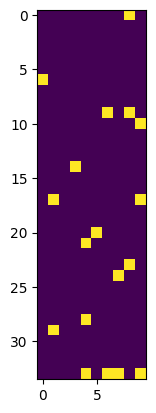

In [30]:
plt.imshow(a[30])
plt.show()

Below we have the structure of the convolutional network.

In [31]:
from tensorflow.keras.layers import (
    Dense,
    Conv2D,
    MaxPool2D,
    Flatten,
    Dropout,
    BatchNormalization,
)

model = Sequential()
model.add(Conv2D(50, (5, 5), strides=1, padding="same", activation="relu", input_shape=(34,10,1)))   
model.add(MaxPool2D((2, 2), strides=1, padding="same"))
model.add(Conv2D(25,(3,3), strides=1, padding='same', activation='relu'))
model.add(MaxPool2D((2, 2), strides=2, padding="same"))
model.add(Dropout(0.3))
model.add(Flatten())
model.add(Dense(units=128, activation="relu"))
model.add(Dense(units=64, activation="relu"))

model.add(Dense(units=num_categories, activation="softmax"))
model.compile(loss="binary_crossentropy", metrics=["accuracy"],optimizer='rmsprop')

C:\Users\gsevr\AppData\Roaming\Python\Python311\site-packages\keras\src\layers\convolutional\base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [32]:
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 34, 10, 50)     │         1,300 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 34, 10, 50)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 34, 10, 25)     │        11,275 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 17, 5, 25)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 17, 5, 25)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 2125)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 128)            │       272,128 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 64)             │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 2)              │           130 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 293,089 (1.12 MB)

 Trainable params: 293,089 (1.12 MB)

 Non-trainable params: 0 (0.00 B)

In [33]:
# visualkeras.layered_view(model,legend=True, to_file='big.png').resize((500,300))

Fitting the model.

In [34]:
history = model.fit(
    a, y_train, epochs=20, verbose=1, validation_data=(b, y_test))

sum(history.history['val_accuracy'])/len(history.history['val_accuracy'])

Epoch 1/20
1549/1549 ━━━━━━━━━━━━━━━━━━━━ 17s 10ms/step - accuracy: 0.5842 - loss: 0.6654 - val_accuracy: 0.6159 - val_loss: 0.6381
Epoch 2/20
1549/1549 ━━━━━━━━━━━━━━━━━━━━ 15s 10ms/step - accuracy: 0.6246 - loss: 0.6370 - val_accuracy: 0.6311 - val_loss: 0.6275
Epoch 3/20
1549/1549 ━━━━━━━━━━━━━━━━━━━━ 14s 9ms/step - accuracy: 0.6334 - loss: 0.6230 - val_accuracy: 0.6389 - val_loss: 0.6188
Epoch 4/20
1549/1549 ━━━━━━━━━━━━━━━━━━━━ 15s 10ms/step - accuracy: 0.6419 - loss: 0.6141 - val_accuracy: 0.6453 - val_loss: 0.6190
Epoch 5/20
1549/1549 ━━━━━━━━━━━━━━━━━━━━ 15s 10ms/step - accuracy: 0.6490 - loss: 0.6102 - val_accuracy: 0.6475 - val_loss: 0.6114
Epoch 6/20
1549/1549 ━━━━━━━━━━━━━━━━━━━━ 15s 10ms/step - accuracy: 0.6570 - loss: 0.6023 - val_accuracy: 0.6472 - val_loss: 0.6092
Epoch 7/20
1549/1549 ━━━━━━━━━━━━━━━━━━━━ 15s 10ms/step - accuracy: 0.6635 - loss: 0.5983 - val_accuracy: 0.6503 - val_loss: 0.6109
Epoch 8/20
1549/1549 ━━━━━━━━━━━━━━━━━━━━ 15s 10ms/step - accuracy: 0.6630 - 

0.644217911362648

The mean accuracy resulting from 20 epochs of training seems satisfactory. At this point we could combine the train and test sets and refit the model, so as to have more data. However, we'll avoid that for computational efficiency, given that the data is of acceptable size.

In the following lines, we're evaluating four conventional classifiers using 10-fold cross-validation.

In [35]:
np.save('training_history.npy', history.history)

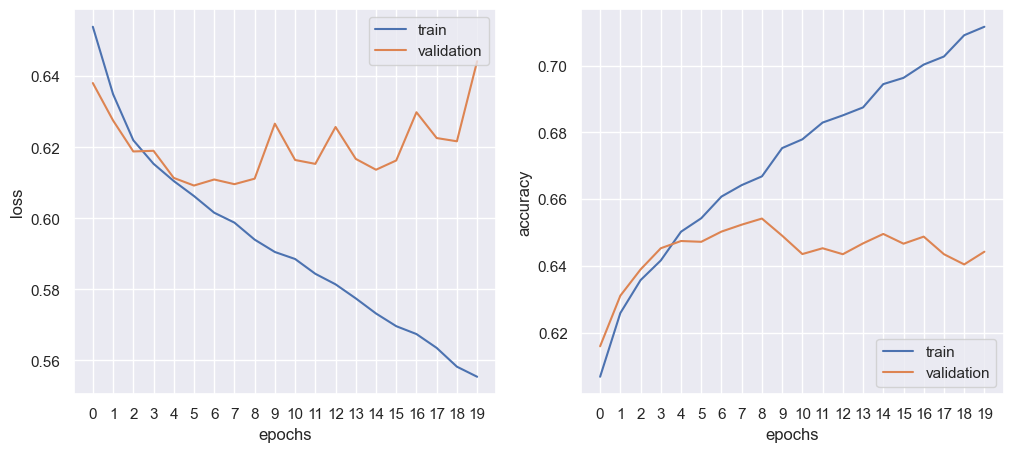

In [36]:
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_theme()

plt.figure(figsize=(12,5))
plt.subplot(1,2,1)
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.xticks([i for i in range(0,20)])
plt.xlabel('epochs')
plt.ylabel('loss')
plt.legend(['train','validation'],loc='upper right')

plt.subplot(1,2,2)
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.xlabel('epochs')
plt.ylabel('accuracy')
plt.legend(['train','validation'],loc='lower right')
plt.xticks([i for i in range(0,20)])

plt.show()

In [37]:
model.save('pretrained_model.keras')

In [39]:
df.to_csv('df.csv',index=False)

In [110]:
classifier = [SVC(),DecisionTreeClassifier(),KNeighborsClassifier(),RandomForestClassifier()]
scoring =['accuracy','recall','precision','f1']

In [ ]:
svc = pd.DataFrame(cross_validate(classifier[0],final_df.iloc[:, :-1],final_df.iloc[:, -1],cv=10,scoring=scoring))
svc.test_accuracy.mean()

In [ ]:
dtc = pd.DataFrame(cross_validate(classifier[1],final_df.iloc[:, :-1],final_df.iloc[:, -1],cv=10,scoring=scoring))
dtc.test_accuracy.mean()

0.5627901136664023

In [ ]:
knn = pd.DataFrame(cross_validate(classifier[2],final_df.iloc[:, :-1],final_df.iloc[:, -1],cv=10,scoring=scoring))
knn.test_accuracy.mean()

0.5363409614440543

In [84]:
a.shape

(49554, 10, 10)

In [89]:
rf = pd.DataFrame(cross_validate(classifier[3],a.reshape(49554,-1),y_train,cv=2,scoring='accuracy'))


In [111]:
rf = classifier[-1]
rf.fit(a.reshape(49554,-1),y_train)

RandomForestClassifier()

In [114]:
np.argsort(rf.feature_importances_)[-3:]

array([321, 322, 310], dtype=int64)

In [115]:
X_train.columns[np.argsort(rf.feature_importances_)[-5:]]

Index(['close', 'foul_away_9', 'away_104', 'home_104', 'foul_home_9'], dtype='object')

Finally, we'll pre-process the '20-'21 season data in the same manner and use our model to make predictions.

In [ ]:
encoders(df_test)
all_runs.clear()
home_runner(df_test)
away_runner(df_test)
all_runs.extend(home_runs)
all_runs.extend(away_runs)
runs_iter(df_test)
runs_df.columns = fact_cols
no_runs_optimized(no_runs_preprocessing(df_test),factors,fact_cols)
no_runs_df.columns = fact_cols
no_runs_df=no_runs_df.sample(frac=0.17)
combined_test_df = pd.concat([runs_df,no_runs_df],ignore_index=True)
final_test_df = combined_test_df.dropna().astype(int)
final_test_df.iloc[:,:-1] = scaler.fit_transform(final_test_df.iloc[:,:-1])
data = final_test_df.iloc[:, :-1].values.reshape(-1,20,10)
data = data / 255
labels = final_test_df.iloc[:, -1]


In [ ]:
preds = model.predict(data)
y_pred = np.argmax(preds, axis = 1)
print(classification_report(labels, y_pred))

82/82 [==============================] - 0s 3ms/step
              precision    recall  f1-score   support

           0       0.65      0.74      0.69      1444
           1       0.61      0.51      0.55      1150

    accuracy                           0.64      2594
   macro avg       0.63      0.62      0.62      2594
weighted avg       0.63      0.64      0.63      2594



Our second goal is to identify the frequency of specific values in our features.

In [ ]:
dec_df = combined_test_df.dropna().astype(int)

for factor in factors:
    for i in range(1,11):
        dec_df[factor+str(i)] = globals()[f'{factor}_le'].inverse_transform(dec_df[factor+str(i)])

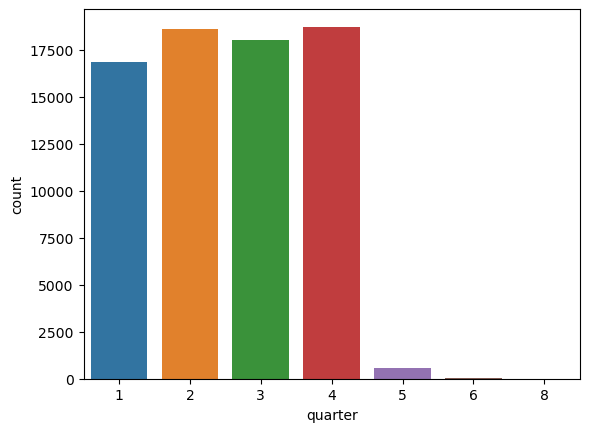

In [ ]:
quarter = dec_df[dec_df['class'] == 1][['Quarter1', 'Quarter2', 'Quarter3', 'Quarter4', 
                     'Quarter5', 'Quarter6', 'Quarter7', 'Quarter8', 
                     'Quarter9', 'Quarter10']]

quarter_df = pd.DataFrame(quarter.stack().reset_index())
del quarter_df['level_0']
del quarter_df['level_1']
quarter_df.columns = ['quarter']
quarter_vc = pd.DataFrame(quarter_df.value_counts())
quarter_vc.columns = ['count']
quarter_vc = quarter_vc.reset_index()
sns.barplot(data=quarter_vc, x='quarter', y='count')
plt.show()

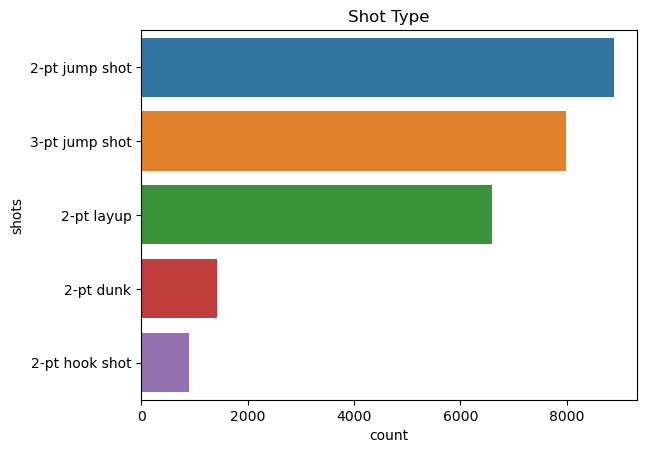

In [ ]:
shots = dec_df[dec_df['class'] == 1][['ShotType1', 'ShotType2', 'ShotType3', 
                   'ShotType4', 'ShotType5', 'ShotType6', 
                   'ShotType7', 'ShotType8', 'ShotType9', 'ShotType10']]

shots_df = pd.DataFrame(shots.stack().reset_index())
del shots_df['level_0']
del shots_df['level_1']
shots_df.columns = ['shots']
shots_vc = pd.DataFrame(shots_df.value_counts())
shots_vc.columns = ['count']
sns.barplot(data = shots_vc.reset_index(), x = 'count', y = 'shots')
plt.title('Shot Type')
plt.show()

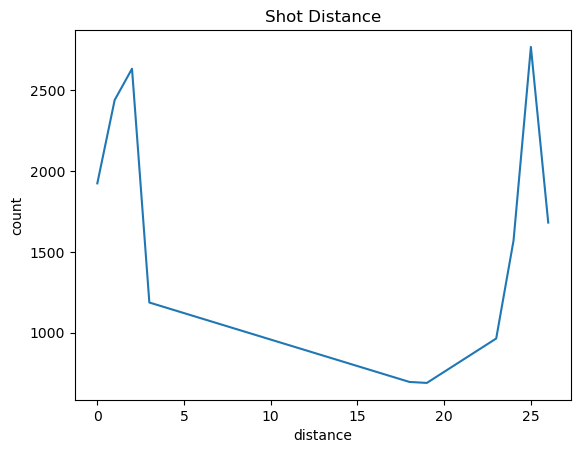

In [ ]:
distance = dec_df[dec_df['class'] == 1][['ShotDist1', 'ShotDist2', 'ShotDist3', 'ShotDist4', 
                  'ShotDist5', 'ShotDist6', 'ShotDist7', 'ShotDist8', 
                  'ShotDist9', 'ShotDist10']]

distance_df = pd.DataFrame(distance.stack().reset_index())
del distance_df['level_0']
del distance_df['level_1']
distance_df.columns = ['distance']
distance_vc = pd.DataFrame(distance_df.value_counts())
distance_vc.columns = ['count']
sns.lineplot(data=distance_vc.reset_index().head(10), x = 'distance', y = 'count')
plt.title('Shot Distance')
plt.show()

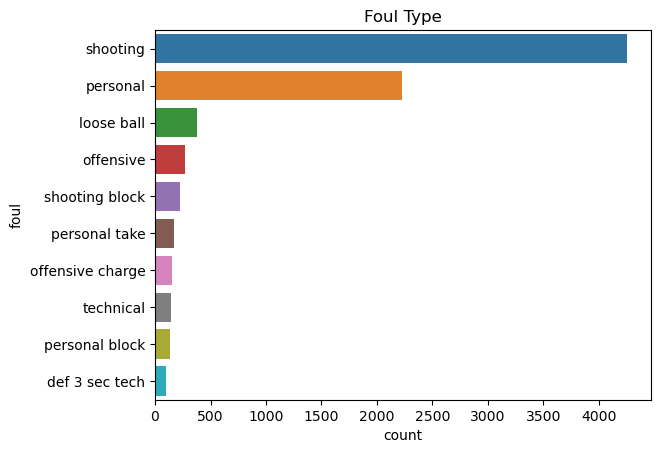

In [ ]:
foul = dec_df[dec_df['class'] == 1][['FoulType1', 'FoulType2', 'FoulType3', 'FoulType4', 
                     'FoulType5', 'FoulType6', 'FoulType7', 'FoulType8', 
                     'FoulType9', 'FoulType10']]

foul_df = pd.DataFrame(foul.stack().reset_index())
del foul_df['level_0']
del foul_df['level_1']
foul_df.columns = ['foul']
foul_vc = pd.DataFrame(foul_df.value_counts())
foul_vc.columns = ['count']
sns.barplot(data=foul_vc.reset_index().head(10), x = 'count', y = 'foul')
plt.title('Foul Type')
plt.show()

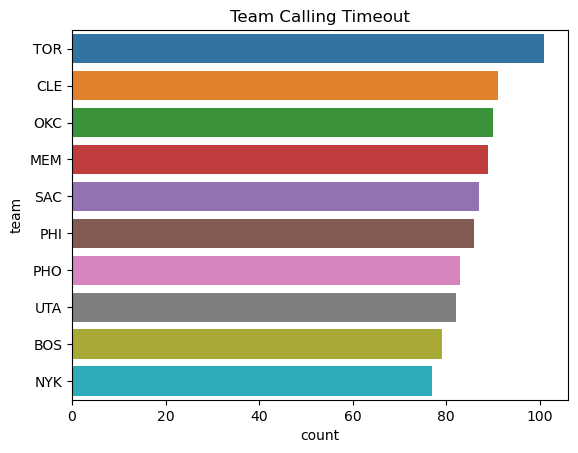

In [ ]:
timeout = dec_df[dec_df['class'] == 1][['TimeoutTeam1', 'TimeoutTeam2', 'TimeoutTeam3', 'TimeoutTeam4', 
                        'TimeoutTeam5', 'TimeoutTeam6', 'TimeoutTeam7', 'TimeoutTeam8',
                        'TimeoutTeam9', 'TimeoutTeam10']]

timeout_df = pd.DataFrame(timeout.stack().reset_index())
del timeout_df['level_0']
del timeout_df['level_1']
timeout_df.columns = ['team']
timeout_vc = pd.DataFrame(timeout_df.value_counts())
timeout_vc.columns = ['count']
sns.barplot(data=timeout_vc.reset_index().head(10), x = 'count', y = 'team')
plt.title('Team Calling Timeout')
plt.show()

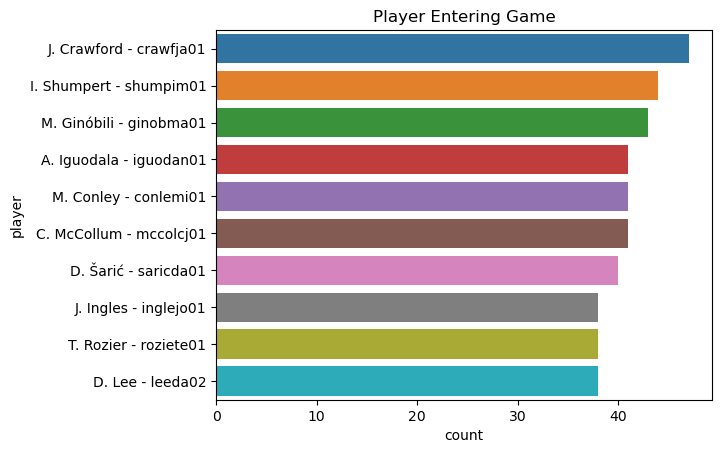

In [ ]:
enter_game = dec_df[dec_df['class'] == 1][['EnterGame1', 'EnterGame2', 'EnterGame3', 'EnterGame4', 
                        'EnterGame5', 'EnterGame6', 'EnterGame7', 'EnterGame8', 
                        'EnterGame9', 'EnterGame10']]

enter_game_df = pd.DataFrame(enter_game.stack().reset_index())
del enter_game_df['level_0']
del enter_game_df['level_1']
enter_game_df.columns = ['player']
enter_game_vc = pd.DataFrame(enter_game_df.value_counts())
enter_game_vc.columns = ['count']
sns.barplot(data=enter_game_vc.reset_index().head(10), x = 'count', y = 'player')
plt.title('Player Entering Game')
plt.show()

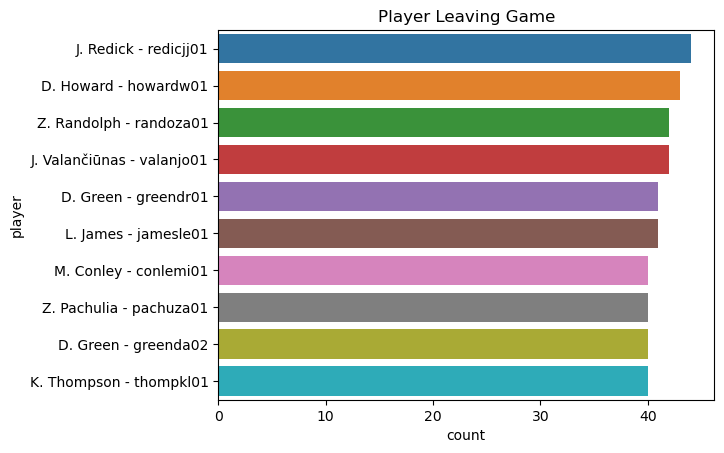

In [ ]:
leave_game = dec_df[dec_df['class'] == 1][['LeaveGame1', 'LeaveGame2', 'LeaveGame3', 'LeaveGame4',
                     'LeaveGame5', 'LeaveGame6', 'LeaveGame7', 'LeaveGame8', 
                     'LeaveGame9', 'LeaveGame10']]

leave_game_df = pd.DataFrame(leave_game.stack().reset_index())
del leave_game_df['level_0']
del leave_game_df['level_1']
leave_game_df.columns = ['player']
leave_game_vc = pd.DataFrame(leave_game_df.value_counts())
leave_game_vc.columns = ['count']
sns.barplot(data=leave_game_vc.reset_index().head(10), x = 'count', y = 'player')
plt.title('Player Leaving Game')
plt.show()

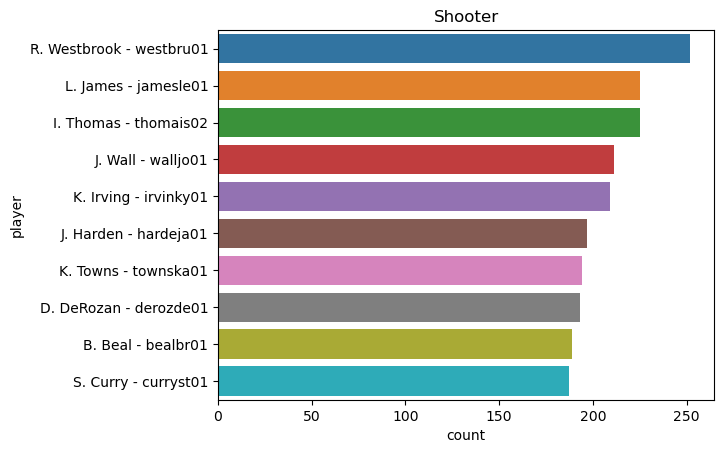

In [ ]:
shooter = dec_df[dec_df['class'] == 1][['Shooter1', 'Shooter2', 'Shooter3', 'Shooter4', 
                     'Shooter5', 'Shooter6', 'Shooter7', 'Shooter8', 
                     'Shooter9', 'Shooter10']]

shooter_df = pd.DataFrame(shooter.stack().reset_index())
del shooter_df['level_0']
del shooter_df['level_1']
shooter_df.columns = ['player']
shooter_df = shooter_df[shooter_df.player != 'Team']
shooter_vc = pd.DataFrame(shooter_df.value_counts())
shooter_vc.columns = ['count']
sns.barplot(data=shooter_vc.reset_index().head(10), x = 'count', y = 'player')
plt.title('Shooter')
plt.show()

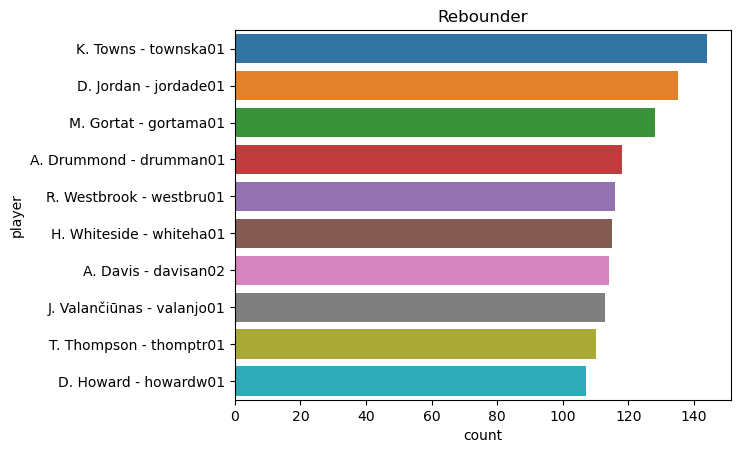

In [ ]:
rebounder = dec_df[dec_df['class'] == 1][['Rebounder1', 'Rebounder2', 'Rebounder3', 
                   'Rebounder4', 'Rebounder5', 'Rebounder6', 
                   'Rebounder7', 'Rebounder8', 'Rebounder9', 'Rebounder10']]

rebounder_df = pd.DataFrame(rebounder.stack().reset_index())
del rebounder_df['level_0']
del rebounder_df['level_1']
rebounder_df.columns = ['player']
rebounder_df = rebounder_df[rebounder_df.player != 'Team']
rebounder_vc = pd.DataFrame(rebounder_df.value_counts())
rebounder_vc.columns = ['count']
sns.barplot(data=rebounder_vc.reset_index().head(10), x = 'count', y = 'player')
plt.title('Rebounder')
plt.show()

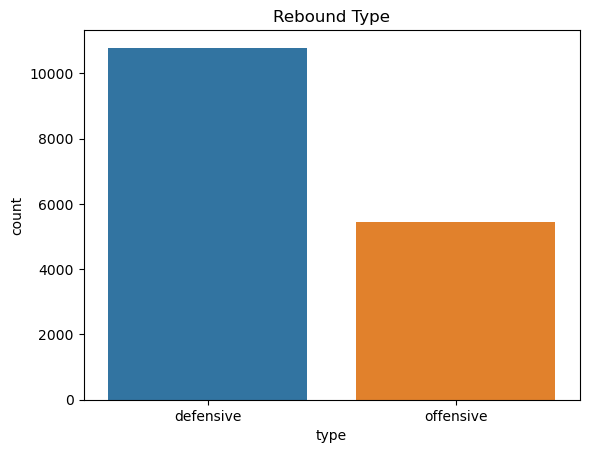

In [ ]:
rebound_type = dec_df[dec_df['class'] == 1][['ReboundType1', 'ReboundType2', 'ReboundType3', 
                   'ReboundType4', 'ReboundType5', 'ReboundType6', 
                   'ReboundType7', 'ReboundType8', 'ReboundType9', 'ReboundType10']]

rebound_type_df = pd.DataFrame(rebound_type.stack().reset_index())
del rebound_type_df['level_0']
del rebound_type_df['level_1']
rebound_type_df.columns = ['type']
rebound_type_df = rebound_type_df[rebound_type_df.type != 'Team']
rebound_type_vc = pd.DataFrame(rebound_type_df.value_counts())
rebound_type_vc.columns = ['count']
sns.barplot(data=rebound_type_vc.reset_index().head(10), x = 'type', y = 'count')
plt.title('Rebound Type')
plt.show()

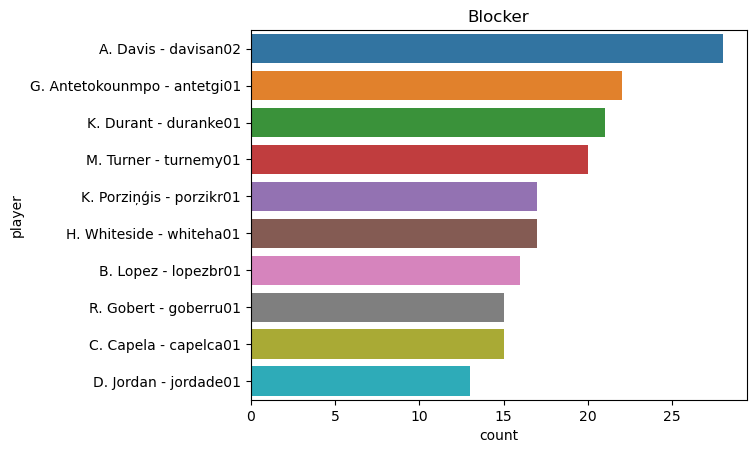

In [ ]:
blocker = dec_df[dec_df['class'] == 1][['Blocker1', 'Blocker2', 'Blocker3', 'Blocker4', 
                     'Blocker5', 'Blocker6', 'Blocker7', 'Blocker8',
                     'Blocker9', 'Blocker10']]

blocker_df = pd.DataFrame(blocker.stack().reset_index())
del blocker_df['level_0']
del blocker_df['level_1']
blocker_df.columns = ['player']
blocker_vc = pd.DataFrame(blocker_df.value_counts())
blocker_vc.columns = ['count']
sns.barplot(data=blocker_vc.reset_index().head(10), x = 'count', y = 'player')
plt.title('Blocker')
plt.show()

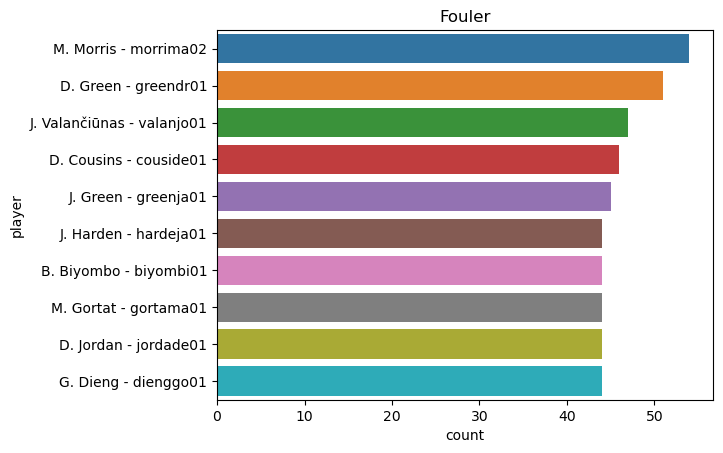

In [ ]:
fouler = dec_df[dec_df['class'] == 1][['Fouler1', 'Fouler2', 'Fouler3', 'Fouler4', 
                     'Fouler5', 'Fouler6', 'Fouler7', 'Fouler8',
                     'Fouler9', 'Fouler10']]

fouler_df = pd.DataFrame(fouler.stack().reset_index())
del fouler_df['level_0']
del fouler_df['level_1']
fouler_df.columns = ['player']
fouler_vc = pd.DataFrame(fouler_df.value_counts())
fouler_vc.columns = ['count']
sns.barplot(data=fouler_vc.reset_index().head(10), x = 'count', y = 'player')
plt.title('Fouler')
plt.show()

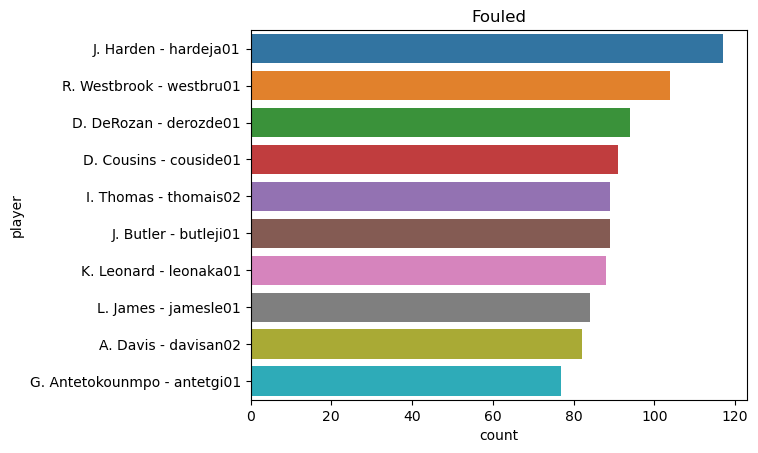

In [ ]:
fouled = dec_df[dec_df['class'] == 1][['Fouled1', 'Fouled2', 'Fouled3', 'Fouled4', 
                     'Fouled5', 'Fouled6', 'Fouled7', 'Fouled8',
                     'Fouled9', 'Fouled10']]

fouled_df = pd.DataFrame(fouled.stack().reset_index())
del fouled_df['level_0']
del fouled_df['level_1']
fouled_df.columns = ['player']
fouled_vc = pd.DataFrame(fouled_df.value_counts())
fouled_vc.columns = ['count']
sns.barplot(data=fouled_vc.reset_index().head(10), x = 'count', y = 'player')
plt.title('Fouled')
plt.show()

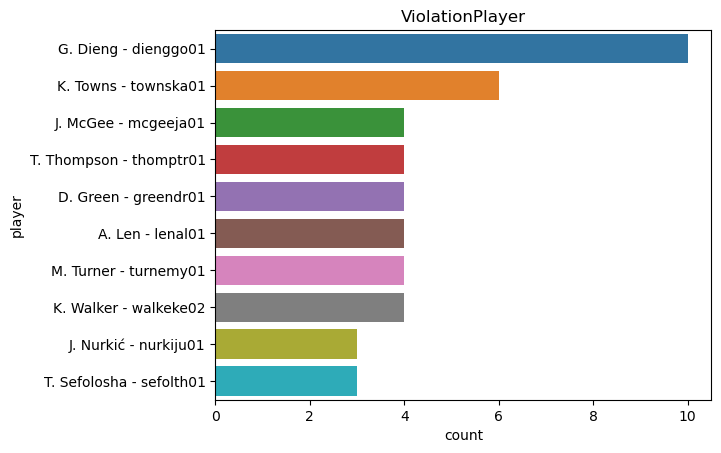

In [ ]:
viol_player = dec_df[dec_df['class'] == 1][['ViolationPlayer1', 'ViolationPlayer2', 'ViolationPlayer3', 'ViolationPlayer4', 
                     'ViolationPlayer5', 'ViolationPlayer6', 'ViolationPlayer7', 'ViolationPlayer8',
                     'ViolationPlayer9', 'ViolationPlayer10']]

viol_player_df = pd.DataFrame(viol_player.stack().reset_index())
del viol_player_df['level_0']
del viol_player_df['level_1']
viol_player_df.columns = ['player']
viol_player_df = viol_player_df[viol_player_df.player != 'Team']
viol_player_vc = pd.DataFrame(viol_player_df.value_counts())
viol_player_vc.columns = ['count']
sns.barplot(data=viol_player_vc.reset_index().head(10), x = 'count', y = 'player')
plt.title('ViolationPlayer')
plt.show()

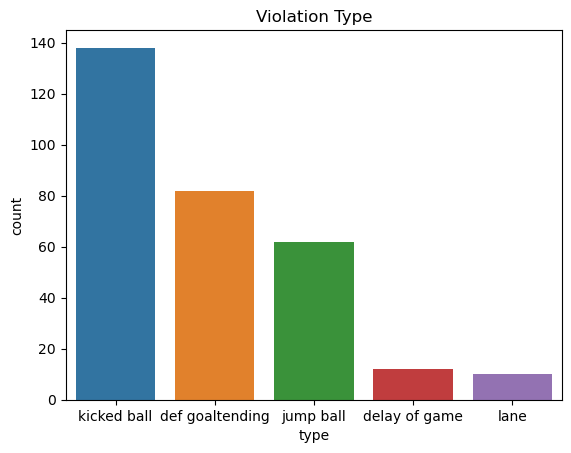

In [ ]:
viol_type = dec_df[dec_df['class'] == 1][['ViolationType1', 'ViolationType2', 'ViolationType3', 
                   'ViolationType4', 'ViolationType5', 'ViolationType6', 
                   'ViolationType7', 'ViolationType8', 'ViolationType9', 'ViolationType10']]

viol_type_df = pd.DataFrame(viol_type.stack().reset_index())
del viol_type_df['level_0']
del viol_type_df['level_1']
viol_type_df.columns = ['type']
viol_type_df = viol_type_df[viol_type_df.type != 'Team']
viol_type_vc = pd.DataFrame(viol_type_df.value_counts())
viol_type_vc.columns = ['count']
sns.barplot(data=viol_type_vc.reset_index().head(10), x = 'type', y = 'count')
plt.title('Violation Type')
plt.show()

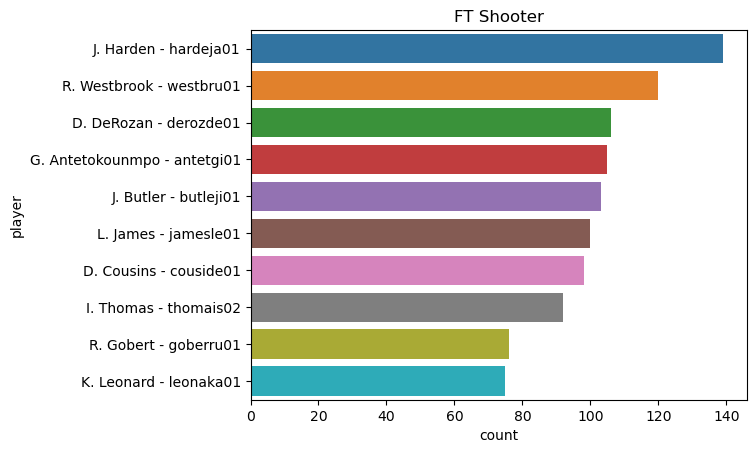

In [ ]:
ft_shooter = dec_df[dec_df['class'] == 1][['FreeThrowShooter1', 'FreeThrowShooter2', 'FreeThrowShooter3', 'FreeThrowShooter4', 
                     'FreeThrowShooter5', 'FreeThrowShooter6', 'FreeThrowShooter7', 'FreeThrowShooter8', 
                     'FreeThrowShooter9', 'FreeThrowShooter10']]

ft_shooter_df = pd.DataFrame(ft_shooter.stack().reset_index())
del ft_shooter_df['level_0']
del ft_shooter_df['level_1']
ft_shooter_df.columns = ['player']
ft_shooter_df = ft_shooter_df[ft_shooter_df.player != 'Team']
ft_shooter_vc = pd.DataFrame(ft_shooter_df.value_counts())
ft_shooter_vc.columns = ['count']
sns.barplot(data=ft_shooter_vc.reset_index().head(10), x = 'count', y = 'player')
plt.title('FT Shooter')
plt.show()

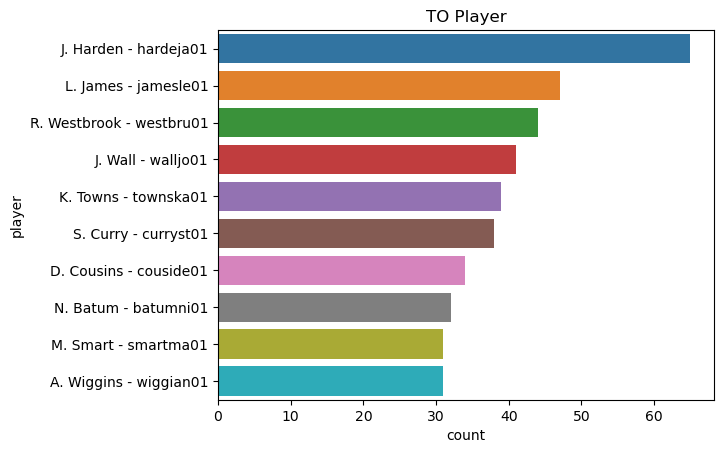

In [ ]:
to_player = dec_df[dec_df['class'] == 1][['TurnoverPlayer1', 'TurnoverPlayer2', 'TurnoverPlayer3', 'TurnoverPlayer4', 
                     'TurnoverPlayer5', 'TurnoverPlayer6', 'TurnoverPlayer7', 'TurnoverPlayer8', 
                     'TurnoverPlayer9', 'TurnoverPlayer10']]

to_player_df = pd.DataFrame(to_player.stack().reset_index())
del to_player_df['level_0']
del to_player_df['level_1']
to_player_df.columns = ['player']
to_player_df = to_player_df[to_player_df.player != 'Team']
to_player_vc = pd.DataFrame(to_player_df.value_counts())
to_player_vc.columns = ['count']
sns.barplot(data=to_player_vc.reset_index().head(10), x = 'count', y = 'player')
plt.title('TO Player')
plt.show()

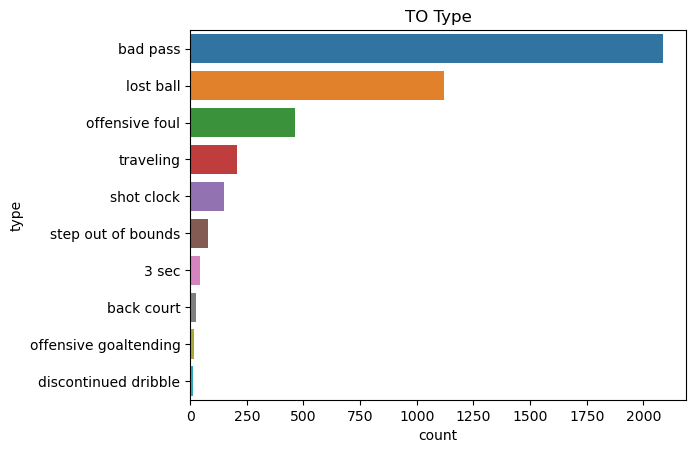

In [ ]:
to_type = dec_df[dec_df['class'] == 1][['TurnoverType1', 'TurnoverType2', 'TurnoverType3', 
                   'TurnoverType4', 'TurnoverType5', 'TurnoverType6', 
                   'TurnoverType7', 'TurnoverType8', 'TurnoverType9', 'TurnoverType10']]

to_type_df = pd.DataFrame(to_type.stack().reset_index())
del to_type_df['level_0']
del to_type_df['level_1']
to_type_df.columns = ['type']
to_type_df = to_type_df[to_type_df.type != 'Team']
to_type_vc = pd.DataFrame(to_type_df.value_counts())
to_type_vc.columns = ['count']
sns.barplot(data=to_type_vc.reset_index().head(10), x = 'count', y = 'type')
plt.title('TO Type')
plt.show()

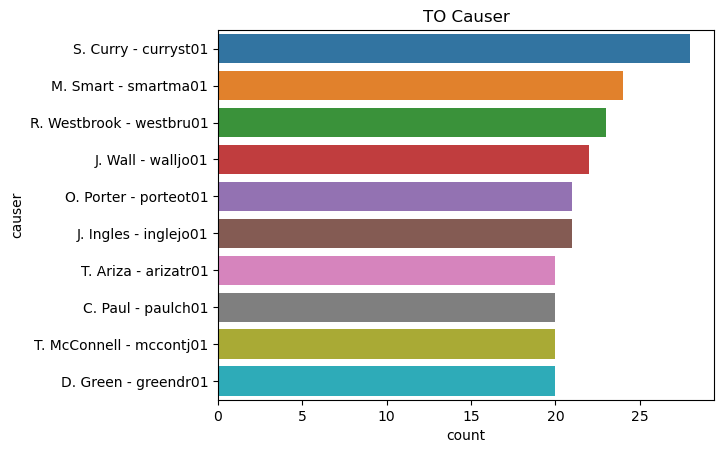

In [ ]:
to_causer = dec_df[dec_df['class'] == 1][['TurnoverCauser1', 'TurnoverCauser2', 'TurnoverCauser3', 
                   'TurnoverCauser4', 'TurnoverCauser5', 'TurnoverCauser6', 
                   'TurnoverCauser7', 'TurnoverCauser8', 'TurnoverCauser9', 'TurnoverCauser10']]

to_causer_df = pd.DataFrame(to_causer.stack().reset_index())
del to_causer_df['level_0']
del to_causer_df['level_1']
to_causer_df.columns = ['causer']
to_causer_df = to_causer_df[to_causer_df.causer != 'Team']
to_causer_vc = pd.DataFrame(to_causer_df.value_counts())
to_causer_vc.columns = ['count']
sns.barplot(data=to_causer_vc.reset_index().head(10), x = 'count', y = 'causer')
plt.title('TO Causer')
plt.show()